In [1]:
%load_ext autoreload

In [38]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import ceil

Device: cuda


[autoreload of mine.models.mine failed: Traceback (most recent call last):
  File "/scratch/network/ls1546/.conda/main/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/scratch/network/ls1546/.conda/main/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/scratch/network/ls1546/.conda/main/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/scratch/network/ls1546/.conda/main/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/scratch/network/ls1546/.conda/main/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/scratch/network/ls1546/.conda/main/lib/python3.10/site-packages/IPython/extensions/autoreload

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224//5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1000


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

# # load part of dataset
# indices = torch.arange(20000)
# dataset_half = torch.utils.data.Subset(dataset, indices)
# dataloader = torch.utils.data.DataLoader(dataset_half, batch_size=batch_size, shuffle=True, num_workers=2)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

cuda:1


In [124]:
224//5

44

In [4]:
# image_dim = 224//5*224//5*3
image_dim = 224//5
mask_size = 5
weights = torch.zeros((image_dim, image_dim))
weights[ceil(image_dim/2-mask_size/2):ceil(image_dim/2+mask_size/2), ceil(image_dim/2-mask_size/2):ceil(image_dim/2+mask_size/2)] = 3

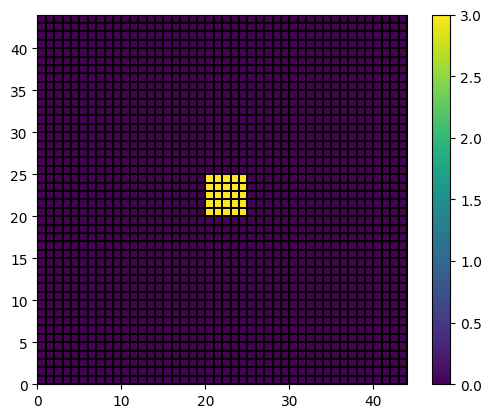

In [5]:
plt.figure()
plt.pcolormesh(weights, edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()

In [6]:
flat_weights = torch.flatten(weights)
flat_weights = torch.cat((flat_weights, flat_weights, flat_weights), dim=-1)
flat_weights = torch.unsqueeze(flat_weights, 0)

In [7]:
# pass images through toy_network to get activations
class Toynetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_dim*image_dim*3, 1)
        self.fc1.weight = torch.nn.Parameter(flat_weights)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

In [8]:
toy_net = Toynetwork().to(device)

In [9]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hook = toy_net.fc1.register_forward_hook(get_activation('fc1'))

In [10]:
inputs_list = []
act_list = []

for inputs, _ in tqdm(dataloader):
    inputs = torch.flatten(inputs, start_dim=1)
    inputs = inputs.to(device)

    with torch.no_grad():
        output = toy_net(inputs)
        
        # collect the activations
        act_list.append(activation['fc1'])

        inputs = inputs.detach().cpu().numpy()
        inputs_list.append(inputs)

    del inputs

# detach the hooks
hook.remove()

100%|███████████████████████████████████████| 100/100 [03:08<00:00,  1.89s/it]


In [11]:
# send X=input images, Y=neuron responses to inputs into MINE, T's weights
# at 1st layer for X should approximate the  weights in toy_net

In [12]:
act_length = (len(act_list) - 1)*batch_size + len(act_list[len(act_list)-1])
act_length, len(act_list), act_list[0].shape, inputs_list[0].shape, inputs_list[-1].shape

(100000, 100, (1000, 1), (1000, 5808), (1000, 5808))

In [13]:
def scale_rgb(x):
    return ((x - x.min()) / (x.max() - x.min()))

In [136]:
x = inputs_list[-1].copy()
x

array([[ 0.05693974,  0.07406463,  0.12543888, ...,  0.5833553 ,
         0.56592613,  0.5484969 ],
       [-1.3130406 , -1.2445416 , -1.3472902 , ...,  0.09533776,
         0.11276696,  0.23477131],
       [ 0.45080918,  0.43368444,  0.43368444, ...,  1.4896734 ,
         1.4896734 ,  1.4722441 ],
       ...,
       [-0.37117907, -0.09718303, -0.09718303, ...,  0.8099348 ,
         0.70535964,  0.6705013 ],
       [ 0.63918144,  0.5364329 ,  0.8446785 , ..., -0.13124175,
        -0.7064052 , -0.63668835],
       [-1.073294  , -1.073294  , -1.0904187 , ..., -0.6192592 ,
        -0.39267966, -0.04409578]], dtype=float32)

In [137]:
print(x.shape)
x = np.reshape(x[-1], (3, 44, 44))
print(x.shape)

(1000, 5808)
(3, 44, 44)


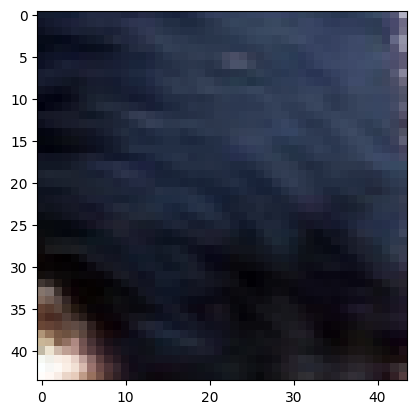

In [138]:
x[0] = scale_rgb(x[0])
x[1] = scale_rgb(x[1])
x[2] = scale_rgb(x[2])
plt.imshow(np.transpose(x, (1,2,0)))

In [14]:
samples = (len(inputs_list) - 1)*batch_size + len(inputs_list[len(inputs_list)-1])
images_flat = np.zeros((samples, (224//5)*(224//5)*3))
responses = np.zeros((act_length, 1))
x_dim=(224//5)*(224//5)*3
y_dim=1

for batch in range(len(act_list)):
    for image in range(len(act_list[batch])):
        responses[batch*len(act_list[0])+image, 0] = act_list[batch][image, 0]
        images_flat[batch*len(act_list[0])+image, :] = inputs_list[batch][image].flatten()

In [15]:
samples, act_length

(100000, 100000)

In [16]:
del act_list, inputs_list

In [142]:
images_flat[-1]

array([-1.07329404, -1.07329404, -1.0904187 , ..., -0.61925918,
       -0.39267966, -0.04409578])

In [17]:
class Lambda(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x)

In [112]:
image_network = nn.Sequential(
    Lambda(lambda x: (x[:,0], x[:,1])),
    nn.Linear(x_dim + y_dim, 1),
    nn.ReLU(),
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 1, bias=False)
        self.fc1y = nn.Linear(y_dim, 1, bias=False)
        self.fc2 = nn.Linear(2, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [38]:
im = Image_network(x_dim, y_dim)

In [42]:
xx = torch.randn(4, 5808)
yy = torch.randn(4, 1)

In [44]:
im(xx, yy)

tensor([[-0.0092],
        [-0.0717],
        [-0.0961],
        [-0.0341]], grad_fn=<AddmmBackward0>)

In [43]:
torch.tensor(images_flat)

tensor([[-2.0323, -2.0323, -2.0323,  ..., -1.7870, -1.7870, -1.7870],
        [ 1.8722,  1.6153,  1.5125,  ..., -1.6650, -1.5081, -1.5081],
        [-0.6281, -0.8335, -0.8507,  ..., -0.5495, -0.7587, -0.7936],
        ...,
        [-1.7069, -1.7240, -1.4843,  ...,  2.1868, -0.1487, -0.6367],
        [ 0.5878,  0.7591,  0.9474,  ...,  0.6356,  0.7751,  0.7402],
        [-0.2342, -0.6452, -0.4739,  ...,  1.5071,  1.3851,  1.2457]],
       dtype=torch.float64)

In [47]:
torch.tensor(images_flat, dtype=torch.float32).to(device)

torch.float32

In [45]:
Image_network(x_dim, y_dim).fc1x.weight.dtype

torch.float32

In [122]:
# image_network = torch.compile(image_network)

mine = Mine(
    T = Image_network(x_dim, y_dim),
    loss = 'mine', #mine_biased, fdiv
    # method = 'concat'
    method = ''
).to(device)
lam = 0.005
mi, loss_log = mine.optimize(torch.tensor(images_flat, dtype=torch.float32).to(device), torch.tensor(responses, dtype=torch.float32).to(device), 1000, batch_size, lam)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [114]:
lam_str = str(lam)
lam_str

'0.005'

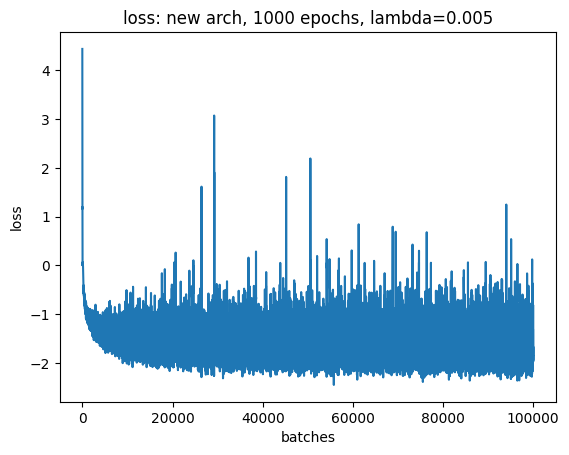

In [115]:
plt.figure()
plt.plot(torch.stack(loss_log).detach().cpu().numpy())
plt.title("loss: new arch, 1000 epochs, lambda="+lam_str)
plt.ylabel("loss")
plt.xlabel("batches")
# plt.show()
plt.savefig("loss"+lam_str+".pdf")

In [116]:
Tweights = mine.T.fc1x.weight.detach().cpu().numpy()[0]
Tweights

array([ 4.8698429e-03, -6.6794244e-05, -3.7820973e-03, ...,
        2.7641382e-03,  5.3031137e-03,  4.3361508e-03], dtype=float32)

In [117]:
unflat_Tweights = np.reshape(Tweights, (3, 224//5,224//5))
unflat_Tweights

array([[[ 4.8698429e-03, -6.6794244e-05, -3.7820973e-03, ...,
         -3.2477372e-03, -5.4835780e-03,  1.0355978e-03],
        [ 3.0011463e-03, -3.0978499e-03,  8.7319165e-03, ...,
          7.2755467e-04,  1.6812127e-03, -3.7364454e-03],
        [-3.0428425e-03, -3.4984481e-03,  3.7426760e-03, ...,
          3.8090660e-03, -6.1323144e-03,  8.5752979e-03],
        ...,
        [ 6.8514296e-03,  8.8124012e-04,  2.8130685e-03, ...,
         -8.5901162e-03, -2.8985376e-03, -6.2337762e-04],
        [ 2.3441617e-03,  2.9260395e-03, -1.5418581e-02, ...,
         -8.9889178e-03, -2.1278530e-03,  9.7665424e-03],
        [-2.6509215e-03,  1.1110577e-03, -7.4586680e-04, ...,
         -2.5295354e-03,  3.5831574e-03,  1.5582710e-04]],

       [[-2.5585145e-03,  3.1318830e-03,  5.1665166e-03, ...,
         -4.0461812e-03, -7.3546534e-03,  9.0794843e-03],
        [-2.5133105e-04,  2.1777649e-03, -9.8522455e-03, ...,
          3.7303024e-03,  5.6805857e-03, -9.9469477e-04],
        [-3.4015989e-03, 

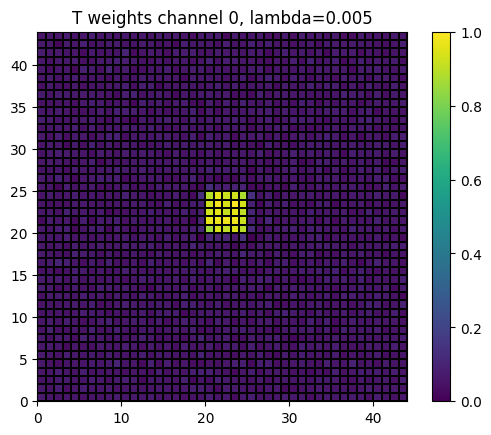

In [118]:
plt.pcolormesh(scale_rgb(unflat_Tweights[0]), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.title("T weights channel 0, lambda="+lam_str)
plt.savefig("Tweightsc0" + lam_str + ".pdf")
# plt.clf()

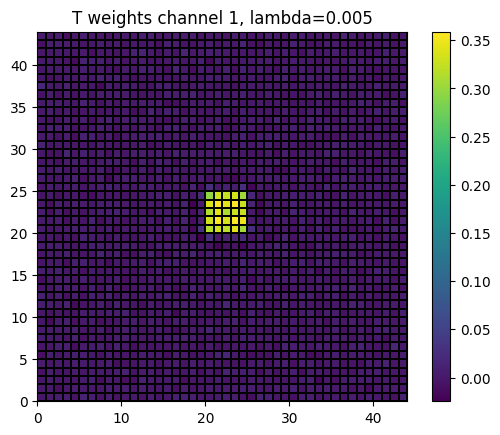

In [119]:
plt.pcolormesh(unflat_Tweights[1], edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.title("T weights channel 1, lambda="+lam_str)
plt.savefig("Tweightsc1" + lam_str + ".pdf")

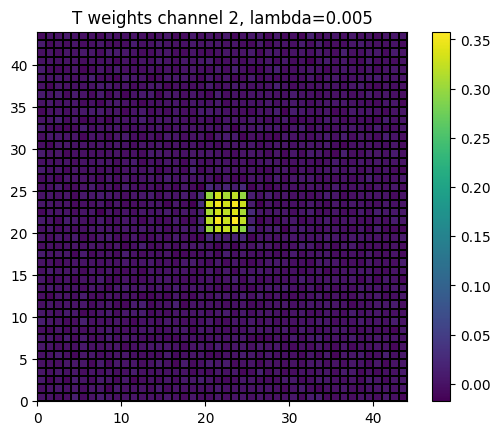

In [120]:
plt.pcolormesh(unflat_Tweights[2], edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.title("T weights channel 2, lambda="+lam_str)
plt.savefig("Tweightsc2" + lam_str + ".pdf")

In [26]:
x = images_flat[-2].copy()
x.shape

(5808,)

In [27]:
unflat_x = np.reshape(x, (3, 224//5,224//5))

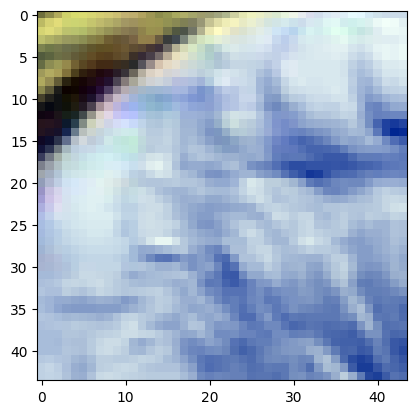

In [28]:
unflat_x[0] = scale_rgb(unflat_x[0])
unflat_x[1] = scale_rgb(unflat_x[1])
unflat_x[2] = scale_rgb(unflat_x[2])
plt.imshow(np.transpose(unflat_x, (1,2,0)))

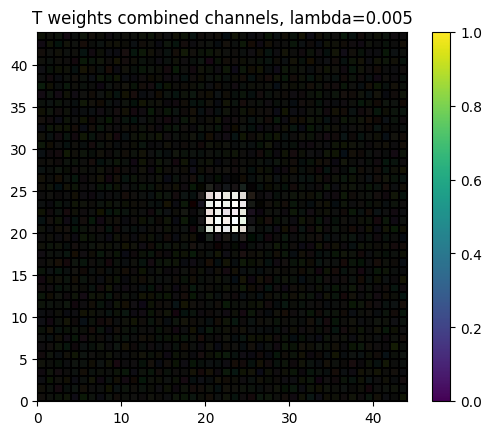

In [121]:
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, unflat_Tweights))), (1,2,0)), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.title("T weights combined channels, lambda="+lam_str)
plt.savefig("Tweightscomb" + lam_str + ".pdf")

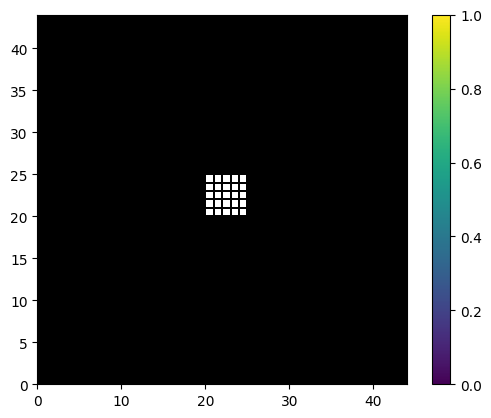

In [67]:
plt.figure()
stack_weights = np.stack([weights, weights, weights])
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, stack_weights))), (1,2,0)), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()

In [35]:
np.save('images_flat_lam.npy', images_flat)
np.save('responses_lam.npy', responses)

In [108]:
torch.save(mine.T, "mineT" + lam_str + ".pth")
np.save("mi" + lam_str + ".npy", mi.detach().cpu().numpy())
np.save("loss" + lam_str + ".npy", torch.stack(loss_log).detach().cpu().numpy())

In [95]:
temp_mi = np.load("mi0.001.npy")

In [98]:
temp_mi

array(1.7075546, dtype=float32)